# Experimentation of Detecting Phishing Links

```bash
conda create --name phisherman python=3.10
pip3 install numpy pandas matplotlib scikit-learn
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 -y
python -m pip install "tensorflow<2.11"
```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM

import os
import requests
import zipfile
import os

## Getting the Data
While serving the web, came across this [webpage](https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset) which contains 134,850 legitimate and 100,945 phishing URLs.

- Provided by University of California, Irvine
- Contains URLS and the labels that can be used for training
- Dataset is used for their paper [A diverse security profile empowered phishing URL detection framework based on similarity index and incremental learning](https://www.sciencedirect.com/science/article/abs/pii/S0167404823004558?via%3Dihub)


In [2]:
def get_dataset():
    """
    Creates a folder named 'dataset' if it doesn't exist.
    :return:
        None
    """
    dest_folder_name = 'dataset'
    dest_csv_name = 'phishing_data.csv'
    csv_link = 'https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip'

    dest_folder_path = os.path.join(os.getcwd(), dest_folder_name)
    dest_file_path = os.path.join(dest_folder_path, dest_csv_name)
    dest_zip_save_path = os.path.join(dest_folder_name, "dataset.zip")


    if not os.path.exists(dest_file_path):
        # Create folder
        os.makedirs(dest_folder_path)
        # Download zip file
        zip_folder = requests.get(csv_link, stream=True)
        zip_folder.raise_for_status()

        with open(dest_zip_save_path, 'wb') as f:
            for chunk in zip_folder.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Zip file downloaded to: {dest_zip_save_path}")

        # Extract the zip file
        with zipfile.ZipFile(dest_zip_save_path, 'r') as zip_ref:
            zip_ref.extractall(dest_folder_path)
        print(f"Zip file extracted to: {dest_folder_path}")

        # Rename csv file to csv_name variable
        old_filepath = os.path.join(dest_folder_path, 'PhiUSIIL_Phishing_URL_Dataset.csv')
        os.rename(old_filepath, dest_file_path)
        print(f"File renamed to '{dest_file_path}'")
        
get_dataset()

In [3]:
phishing_df = pd.read_csv("dataset/phishing_data.csv")
phishing_df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


## Exploration

In [4]:
phishing_df_url_labels = phishing_df[['URL', 'label']]

In [5]:
phishing_df_url_labels[phishing_df_url_labels["label"] == 0].head()

,URL,label
11,http://www.teramill.com,0
20,http://www.f0519141.xsph.ru,0
21,http://www.shprakserf.gq,0
27,https://service-mitld.firebaseapp.com/,0
28,http://www.kuradox92.lima-city.de,0


In [6]:
phishing_df_url_labels[phishing_df_url_labels["label"] == 1].head()

,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


In [7]:
phishing_df_url_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     235795 non-null  object
 1   label   235795 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
check_label_counts = phishing_df_url_labels.groupby(by="label", axis=0).count()
check_label_counts.index = ['Non-Phishing', 'Phishing']

check_label_counts

C:\Users\lelop\AppData\Local\Temp\ipykernel_1324\2867867651.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  check_label_counts = phishing_df_url_labels.groupby(by="label", axis=0).count()


,URL
Non-Phishing,100945
Phishing,134850


## Spliting Train and Test set

In [9]:
X = phishing_df_url_labels['URL']
y = phishing_df_url_labels['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y, train_size=0.3
)

In [10]:
len(X_train)

70738

In [11]:
len(X_test)

165057

## Experimenting with Simple AI Architectures

### Data Processing

In [12]:
# Initialize tokenizer with an OOV token.
tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1  # plus one for padding token
sequences = tokenizer.texts_to_sequences(X_train)
max_length = max(len(seq) for seq in sequences)

In [13]:
def convert_url_padding(data):
    # Convert URLs to sequences and pad them
    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")
    return padded_sequences

### Creating a CNN Model

In [14]:
def create_cnn_model(vocab_size, embedding_dim, input_length):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, mask_zero=True)(inputs)
    
    # A 1D convolution layer to capture n-gram features
    x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Binary classification output
    output_class = Dense(1, activation='sigmoid', name='binary_class')(x)
    model = Model(inputs, output_class)
    return model

# Create the CNN model
embedding_dim = 50  # You can experiment with this size
cnn_model = create_cnn_model(vocab_size, embedding_dim, input_length=max_length)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# cnn_model.summary()

### Creating a RNN Model

In [15]:
def create_rnn_model(vocab_size, embedding_dim, input_length):
    inputs = Input(shape=(input_length,))
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=input_length,
        mask_zero=True,
    )(inputs)
    # An LSTM layer to capture sequential patterns
    x = LSTM(128, return_sequences=False)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    # Binary classification output
    output_class = Dense(1, activation="sigmoid", name="binary_class")(x)
    model = Model(inputs, output_class)
    return model


# Create the RNN model
rnn_model = create_rnn_model(
    vocab_size, embedding_dim, input_length=max_length
)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(
    optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"]
)
# rnn_model.summary()

### Training 

In [16]:
X_train_encoding = convert_url_padding(X_train)
X_test_encoding = convert_url_padding(X_test)

In [17]:
# Assuming X_train, y_train, X_val, y_val have been defined appropriately
history_cnn = cnn_model.fit(
    X_train_encoding,
    y_train,
    epochs=1,
    validation_split=0.3,
    batch_size=32,
)

history_rnn = rnn_model.fit(
    X_train_encoding,
    y_train,
    epochs=1,
    validation_split=0.3,
    batch_size=32,
)

1548/1548 [==============================] - 62s 37ms/step - loss: 0.2253 - accuracy: 0.8996 - val_loss: 0.0244 - val_accuracy: 0.9938


In [18]:
# After training, compare accuracy:
cnn_accuracy = cnn_model.evaluate(X_test_encoding, y_test)
rnn_accuracy = rnn_model.evaluate(X_test_encoding, y_test)
print("CNN Accuracy:", cnn_accuracy)
print("RNN Accuracy:", rnn_accuracy)

5159/5159 [==============================] - 71s 14ms/step - loss: 0.0236 - accuracy: 0.9942
CNN Accuracy: [0.014300916343927383, 0.9976553320884705]
RNN Accuracy: [0.023612914606928825, 0.994208037853241]


In [19]:
cnn_model.predict(
    convert_url_padding(
        [
            "https://www.southbankmosaics.com",
            "http://activate.facebook.fblogins.net/88adbao798283o8298398?login.asp",
            "http://www.buy.com.money.ru",
            "http://jhomitevd2abj3fk.onion.to/",
            "premierpaymentprocessing.com/includes/boleto-2via-07-2012.php",
            "scamme.com",
            "stealyourmoney.com",
            "paynow.paypay.com",
            "https://pornhut.com",
            "https://paypalll.com"
        ]
    )
) > 0.1

1/1 [==============================] - 0s 174ms/step


array([[ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False]])

In [20]:
y_pred = cnn_model.predict(X_test_encoding)

5159/5159 [==============================] - 39s 8ms/step


In [21]:
y_pred_int = (y_pred > 0.5).astype(int)

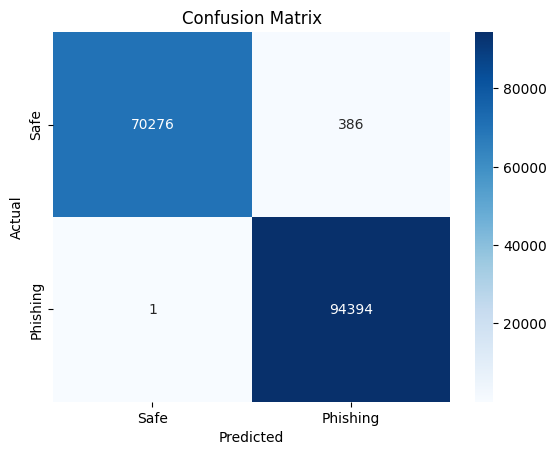

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_int)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
f1 = f1_score(y_test, y_pred_int)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9959
Recall: 1.0000
F1 Score: 0.9980


# IGNORE CODE BELOW

## Prepare URL to Character embeddings

In [24]:
# Inputs to the model
vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 1), lowercase=True)
X = vectorizer.fit_transform(phishing_df_url_labels['URL'])

NameError: name 'CountVectorizer' is not defined

In [ ]:
vectorizer.get_feature_names_out()

array(['!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.',
       '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
       '=', '?', '@', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
       'u', 'v', 'w', 'x', 'y', 'z', '~', '¢', '£', '¤', '¬', '¹', 'â',
       'ã', 'å', '‚', '“', '€'], dtype=object)

In [ ]:
y = phishing_df_url_labels['label'].to_numpy()

In [ ]:
y[:5]

array([1, 1, 1, 1, 1])

## Spliiting to Train and Test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
print("Training Data:", X_train.shape[0])
print("Testing Data:", X_test.shape[0])

Training Data: 165056
Testing Data: 70739


## Baseline Model

In [ ]:
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train[:100000], y_train[:100000])

RandomForestClassifier(random_state=42)

## Evaluate Model

In [ ]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     30284
           1       0.90      1.00      0.95     40455

    accuracy                           0.94     70739
   macro avg       0.95      0.93      0.93     70739
weighted avg       0.94      0.94      0.94     70739

ROC AUC Score: 0.9572529520359326
